In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

## System Transformation - 2045

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2045
year_baseline = 2012

start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:00:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [4]:
import add_P2G
add_P2G.add_P2G(year, scenario=scenario)

In [5]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data_P2G')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon S.W.Penisula', 'Tidal stream Deeside',
       'Tidal stream Lovedean', 'Tidal stream Melksham',
       'Tidal stream Penwortham', 'Tidal stream S.W.Penisula',
       'Wave power Beauly', 'Wave power Melksham', 'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data_P2G has buses, generators, lines, links, loads, storage_units


In [6]:
B6_capacity_data = {'2021': 6100,
                    '2030': 11500,
                    '2035': 11500,
                    '2040': 16900,
                    '2045': 16900}
B6_capacity = B6_capacity_data[str(year)]

# scale the B6 lines to system transformation economy RT
B6 = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
# network.lines
scaling_factor = B6_capacity / B6
network.lines.s_nom *= scaling_factor
B6_scaled = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
B6_scaled

16899.999999999996

In [7]:
# derate CCS gas to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'CCS Gas'), "p_nom"] *= 0.

In [8]:
# derate hydrogen to 0% of capacity across Scotland
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Hydrogen'), "p_nom"] *= 0.

In [9]:
# limit biomass to 230MW capacity across Scotland 2040 onwards
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
for bus in buses_scotland:
    if year >= 2040:
        network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'Biomass (dedicated)'), "p_nom"] = 0.
        network.generators.loc[(network.generators['bus'] == bus) & (network.generators['carrier'] == 'CCS Biomass'), "p_nom"] = 0.

In [10]:
# scale up loads according to Consumer Transformation peak demand
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_loads_scotland = network.loads[network.loads.bus.isin(buses_scotland)]
network.loads_t.p_set.loc[:, buses_scotland].sum(axis=1).max()

peak_demand_data = {'2021': 4600 ,
                    '2030': 5900,
                    '2035': 8000,
                    '2040': 10200,
                    '2045': 11300}
unscaled_peak = network.loads_t.p_set[buses_scotland].sum(axis=1).max()
load_scale = peak_demand_data[str(year)] / unscaled_peak

network.loads_t.p_set.loc[:, buses_scotland] *= load_scale
# print(unscaled_peak)
# print(load_scale)
# print(network.loads_t.p_set.loc[:, buses_scotland].sum(axis=1).max())

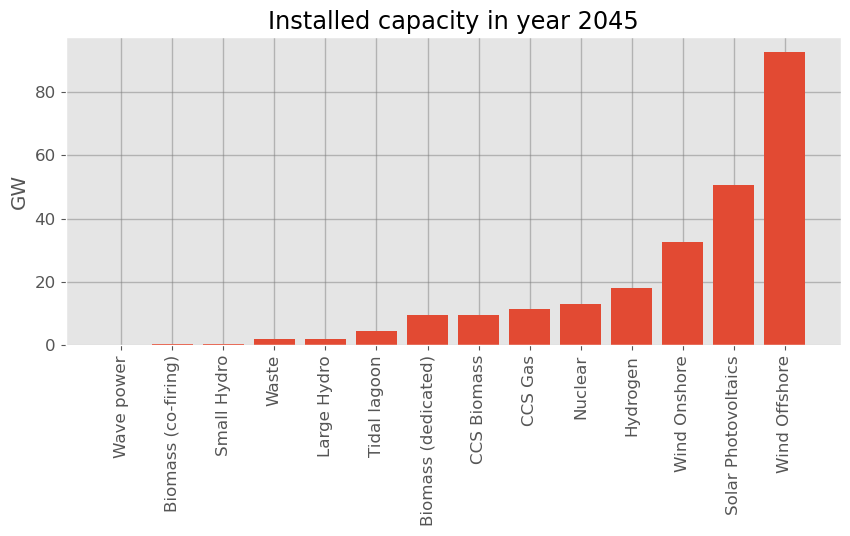

In [11]:
generators_p_nom = network.generators.p_nom.groupby(
    network.generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

In [12]:
generators_p_nom

carrier
Wave power               171.000000
Biomass (co-firing)      224.400000
Small Hydro              252.495941
Waste                   1809.134000
Large Hydro             1926.906038
Tidal lagoon            4505.000000
Biomass (dedicated)     9456.737510
CCS Biomass             9600.717370
CCS Gas                11360.000000
Nuclear                12922.000000
Hydrogen               18026.805006
Wind Onshore           32663.170000
Solar Photovoltaics    50666.540000
Wind Offshore          92649.070000
Name: p_nom, dtype: float64

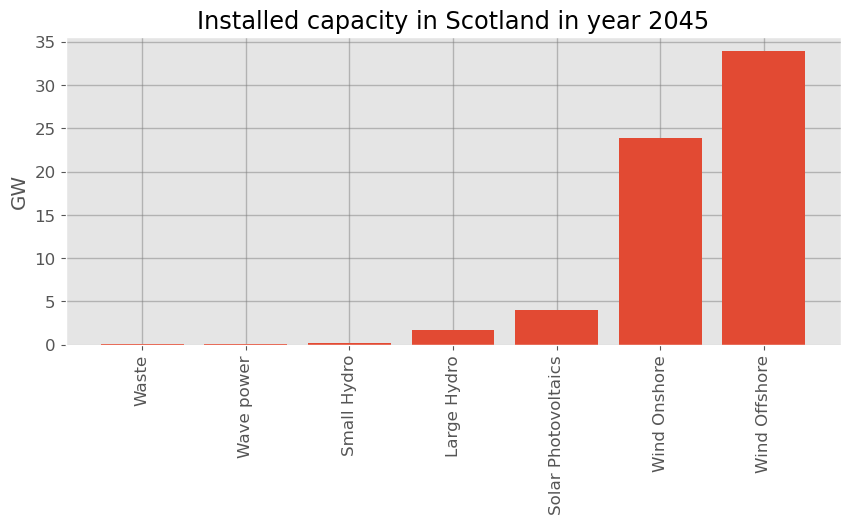

In [13]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]

generators_p_nom_scotland = df_generators_scotland.p_nom.groupby(
    df_generators_scotland.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom_scotland.drop('Unmet Load', inplace=True)
generators_p_nom_scotland.drop(generators_p_nom_scotland[generators_p_nom_scotland < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom_scotland.index, generators_p_nom_scotland.values / 1000)
plt.xticks(generators_p_nom_scotland.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in Scotland in year ' + str(year))
plt.show()

In [14]:
generators_p_nom_scotland

carrier
Waste                     62.176000
Wave power               113.000000
Small Hydro              230.913108
Large Hydro             1691.699577
Solar Photovoltaics     3947.294084
Wind Onshore           23890.538179
Wind Offshore          33901.090000
Name: p_nom, dtype: float64

In [15]:
buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]
storage_by_carrier_scotland = df_storage_scotland.p_nom.groupby(df_storage_scotland.carrier).sum()
storage_by_carrier_scotland

carrier
Battery                          2111.132824
Compressed Air                   1104.358621
Liquid Air                        552.993103
P2G                             11860.807491
Pumped Storage Hydroelectric     2012.000000
Name: p_nom, dtype: float64

In [16]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 72.86s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-g1ygb54b.lp
Reading time = 47.05 seconds
obj: 25298024 rows, 7892761 columns, 44437648 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25298024 rows, 7892761 columns and 44437648 nonzeros
Model fingerprint: 0x0b8fa487
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 6e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23239436 rows and 1459123 columns (presolve time = 5s) ...
Presolve removed 23249193 rows and 2650000 columns (presolve time = 10s) 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09


('ok', 'optimal')

In [17]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})

p_by_carrier

carrier,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,...,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,P2G,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2045-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,321.719175,0.0,0.000000,0.0,...,0.0,15.38914,66264.364776,13539.907788,2291.559539,0.000000,0.000000,0.0,1.199355,0.0
2045-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,264.743035,0.0,0.000000,0.0,...,0.0,13.99714,64744.464141,13914.205519,0.000000,0.000000,0.000000,0.0,55.514649,0.0
2045-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,264.537008,0.0,0.000000,0.0,...,0.0,13.99714,64188.333289,15844.159211,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2045-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,314.601256,0.0,0.000000,0.0,...,0.0,13.99714,63184.202247,16263.912170,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2045-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,390.212690,0.0,0.000000,0.0,...,0.0,13.99714,62829.798746,17100.691103,0.000000,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,570.822408,0.0,2019.646346,0.0,...,0.0,16.62686,62498.421813,10955.596215,3769.094201,1775.586900,194.155945,0.0,2982.866247,0.0
2045-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,537.686978,0.0,2270.204271,0.0,...,0.0,16.62686,63528.102112,11022.470426,5507.058290,992.904190,724.130161,0.0,1856.693723,0.0
2045-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,483.401273,0.0,2019.646346,0.0,...,0.0,16.62686,64084.941151,10530.255937,0.000000,1257.976599,781.645524,0.0,2315.746073,0.0


Text(0.5, 0, '')

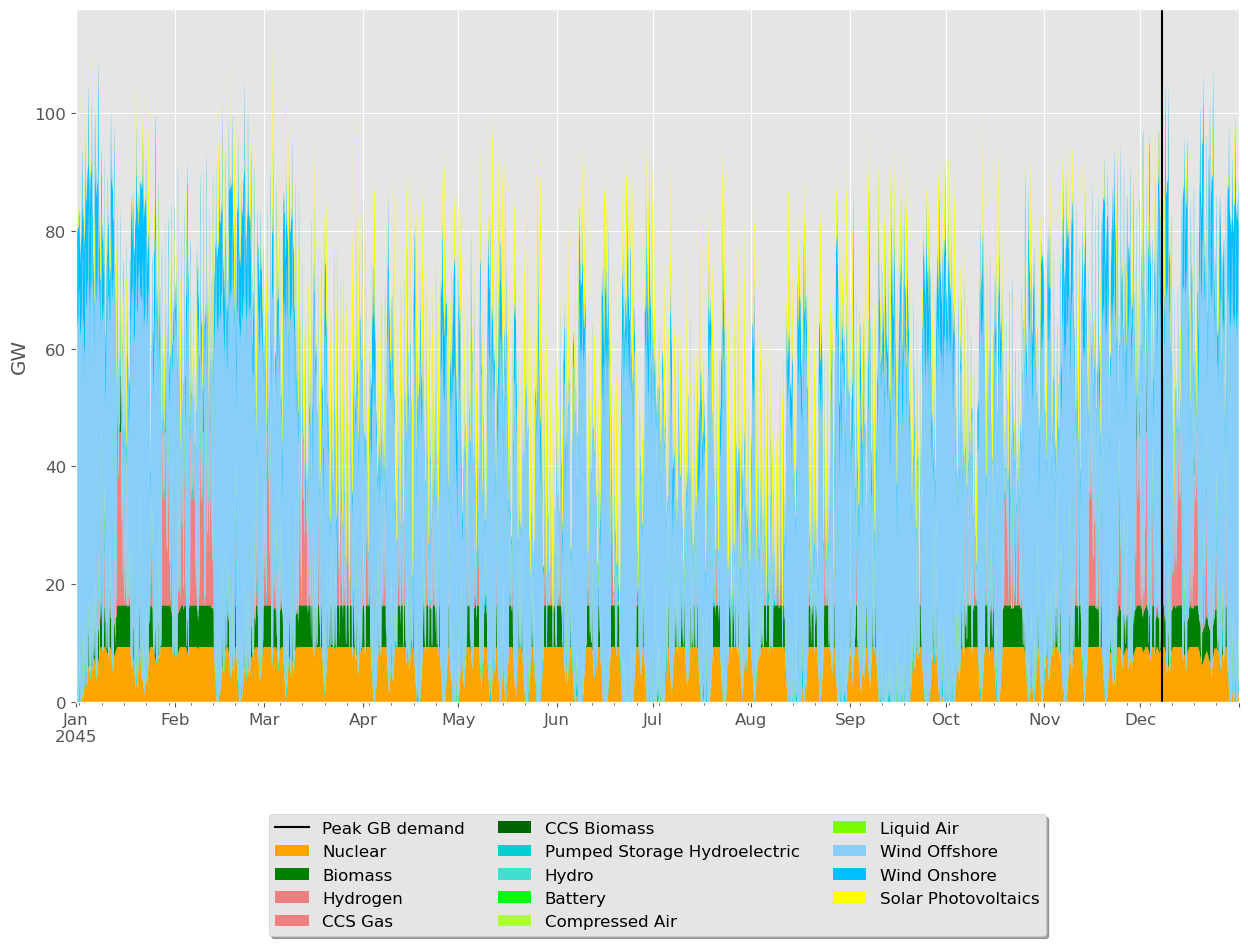

In [18]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

ax.set_ylabel("GW")

ax.set_xlabel("")

In [19]:

buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]

p_by_carrier_scotland = network.generators_t.p[df_generators_scotland.index.values].groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier_scotland = network.storage_units_t.p[df_storage_scotland.index.values].groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier_scotland[storage_by_carrier_scotland < 0] = 0

p_by_carrier_scotland = pd.concat([p_by_carrier_scotland, storage_by_carrier_scotland], axis=1)

In [20]:
network.lines_t.p0[['17', '18', '23', '24', '16']]
B6_to_scotland = network.lines_t.p0[['17', '18', '23', '24', '16']]

B6_import = B6_to_scotland.copy()
B6_export = B6_to_scotland.copy()

B6_import[B6_import > 0] = 0
B6_import = B6_import.sum(axis=1) * -1

B6_export[B6_export < 0] = 0
B6_export = B6_export.sum(axis=1) * -1
B6_export.name = 'B6 export'

snapshot
2045-01-01 00:00:00   -5199.004658
2045-01-01 01:00:00   -4938.221193
2045-01-01 02:00:00   -4947.790621
2045-01-01 03:00:00   -4784.172711
2045-01-01 04:00:00   -4320.592764
                          ...     
2045-12-31 19:00:00   -4950.824728
2045-12-31 20:00:00   -5264.744039
2045-12-31 21:00:00   -5831.064572
2045-12-31 22:00:00   -2964.912281
2045-12-31 23:00:00   -3108.795855
Name: B6 export, Length: 8760, dtype: float64


c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

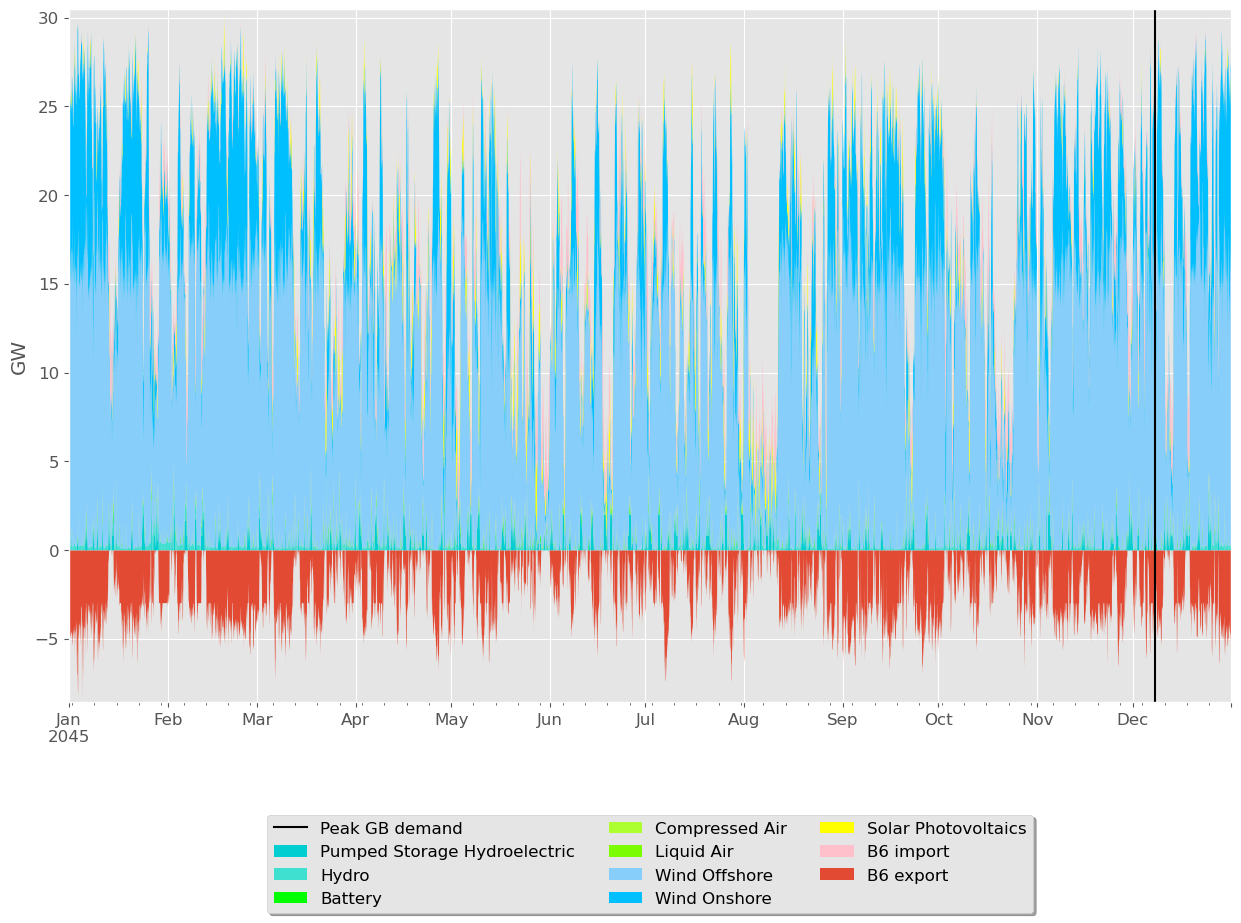

In [21]:
# group biomass stuff
p_by_carrier_scotland['Biomass'] = (
    p_by_carrier_scotland['Biomass (dedicated)'])

# add B6 flows
p_by_carrier_scotland['B6 import'] = B6_import

# rename the hydro bit
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Interconnector': 'Interconnectors Import'})

cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load', 'B6 import'
        ]

p_by_carrier_scotland = p_by_carrier_scotland[cols]

p_by_carrier_scotland.drop(
    (p_by_carrier_scotland.max()[p_by_carrier_scotland.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier_scotland / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier_scotland.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(B6_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
print(B6_export)
ax.set_ylim(B6_export.min() / 1e3, (p_by_carrier_scotland / 1e3).sum(axis=1).max())

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("GW")

ax.set_xlabel("")


In [22]:
network.export_to_csv_folder('LC_HD_data')

INFO:pypsa.io:Exported network LC_HD_data has lines, storage_units, links, generators, buses, loads


## Import and export analysis